# Data Splitting

In [1]:
# import os
# import shutil
# import random
# from sklearn.model_selection import train_test_split

# # Define paths
# train_dir = 'dataset/train'
# val_dir = 'dataset/val'

# # Calculate the number of classes based on directories in the train folder
# classes = [d.name for d in os.scandir(train_dir) if d.is_dir()]
# num_classes = len(classes)
# print(f"Number of classes: {num_classes}")

Number of classes: 114


In [4]:
# def split_data(train_dir, val_dir, split_size=0.2):
#     for cls in classes:
#         cls_dir = os.path.join(train_dir, cls)
#         images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.JPG')]

#         # Check if there are images in the class directory
#         if len(images) == 0:
#             print(f"No images found in class {cls}. Skipping this class.")
#             continue

#         # Split the data
#         train_imgs, val_imgs = train_test_split(images, test_size=split_size)

#         # Create corresponding directory in val_dir
#         val_cls_dir = os.path.join(val_dir, cls)
#         os.makedirs(val_cls_dir, exist_ok=True)

#         # Move/copy validation images
#         for img in val_imgs:
#             shutil.move(img, val_cls_dir)  # Use shutil.copy if you want to keep the original

# # Call the function to split the data
# split_data(train_dir, val_dir)

# Train

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/val', transform=transform)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

# Load Pre-trained DeiT Model
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust the classifier for your number of classes
num_classes = len(train_dataset.classes)
model.head = nn.Linear(model.head.in_features, num_classes)

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main
/home/samxu/documents/apply_ai/final_fungus-detector/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in model.head.parameters():
    param.requires_grad = True

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [5]:
torch.cuda.is_available()

True

In [8]:
import copy
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs} [{phase}]"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model


# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------


Epoch 1/10 [train]: 100%|██████████| 241/241 [01:02<00:00,  3.86it/s]


train Loss: 1.9965 Acc: 0.5176


Epoch 1/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 2.1629 Acc: 0.4601

Epoch 2/10
----------


Epoch 2/10 [train]: 100%|██████████| 241/241 [01:01<00:00,  3.89it/s]


train Loss: 1.5394 Acc: 0.6282


Epoch 2/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 1.9746 Acc: 0.4955

Epoch 3/10
----------


Epoch 3/10 [train]: 100%|██████████| 241/241 [01:02<00:00,  3.83it/s]


train Loss: 1.2686 Acc: 0.6921


Epoch 3/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 1.8536 Acc: 0.5086

Epoch 4/10
----------


Epoch 4/10 [train]: 100%|██████████| 241/241 [01:01<00:00,  3.94it/s]


train Loss: 1.0707 Acc: 0.7507


Epoch 4/10 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.91it/s]


val Loss: 1.8030 Acc: 0.5262

Epoch 5/10
----------


Epoch 5/10 [train]: 100%|██████████| 241/241 [01:02<00:00,  3.88it/s]


train Loss: 0.9277 Acc: 0.7906


Epoch 5/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 1.7429 Acc: 0.5368

Epoch 6/10
----------


Epoch 6/10 [train]: 100%|██████████| 241/241 [01:02<00:00,  3.85it/s]


train Loss: 0.8119 Acc: 0.8188


Epoch 6/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 1.7181 Acc: 0.5510

Epoch 7/10
----------


Epoch 7/10 [train]: 100%|██████████| 241/241 [01:01<00:00,  3.92it/s]


train Loss: 0.7207 Acc: 0.8496


Epoch 7/10 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.91it/s]


val Loss: 1.6921 Acc: 0.5530

Epoch 8/10
----------


Epoch 8/10 [train]: 100%|██████████| 241/241 [01:02<00:00,  3.85it/s]


train Loss: 0.6438 Acc: 0.8697


Epoch 8/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 1.6895 Acc: 0.5636

Epoch 9/10
----------


Epoch 9/10 [train]: 100%|██████████| 241/241 [01:02<00:00,  3.83it/s]


train Loss: 0.5782 Acc: 0.8899


Epoch 9/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 1.6933 Acc: 0.5540

Epoch 10/10
----------


Epoch 10/10 [train]: 100%|██████████| 241/241 [01:03<00:00,  3.82it/s]


train Loss: 0.5256 Acc: 0.8994


Epoch 10/10 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]

val Loss: 1.6820 Acc: 0.5610

Best val Acc: 0.563572


In [10]:
model_name = 'deit_fungus25-epoch10.pth'
torch.save(model.state_dict(), model_name)

# Inference

In [19]:
from PIL import Image
import os

num_classes = len(os.listdir('dataset/train'))  # Count subdirectories in train dir
num_classes

115

In [26]:
# Load the pre-trained DeiT model
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

# Modify the final layer to match the original training configuration
model.head = torch.nn.Linear(model.head.in_features, 114)  

# Load the saved weights
model.load_state_dict(torch.load(model_name))

# Now modify the final layer again to match the current number of classes (if necessary)
model.head = torch.nn.Linear(model.head.in_features, num_classes)

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main


In [27]:
def classify_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()


In [28]:
class_names = os.listdir('dataset/train')  # Assuming class names are folder names
class_names.sort()  # Sort the class names
# class_names

In [30]:
# Example usage
image_path = 'dataset/test/11746_Clitocybe_agrestis/AS2010PIC11659685.JPG'
predicted_class_index = classify_image(image_path, model, transform)
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted class: {predicted_class_name}')

Predicted class: 16111_Leccinum_scabrum


In [32]:
import matplotlib.pyplot as plt
import random

def select_random_images(path, num_images=5):
    all_images = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    
    return random.sample(all_images, min(num_images, len(all_images)))


In [49]:
import os

def display_predictions(images, model, transform):
    num_images = len(images)
    plt.figure(figsize=(10, num_images * 3))  # Adjust size as needed

    for i, image_path in enumerate(images, 1):
        img = Image.open(image_path)
        img_transformed = transform(img).unsqueeze(0)

        with torch.no_grad():
            outputs = model(img_transformed)
            _, predicted = torch.max(outputs, 1)
            predicted_class_name = class_names[predicted.item()]

        # Extracting parent directory and file name
        file_parent_dir = os.path.basename(os.path.dirname(image_path))
        file_path = os.path.basename(image_path)

        plt.subplot(num_images, 1, i)
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class_name}\nSource: {file_parent_dir}/{file_path}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

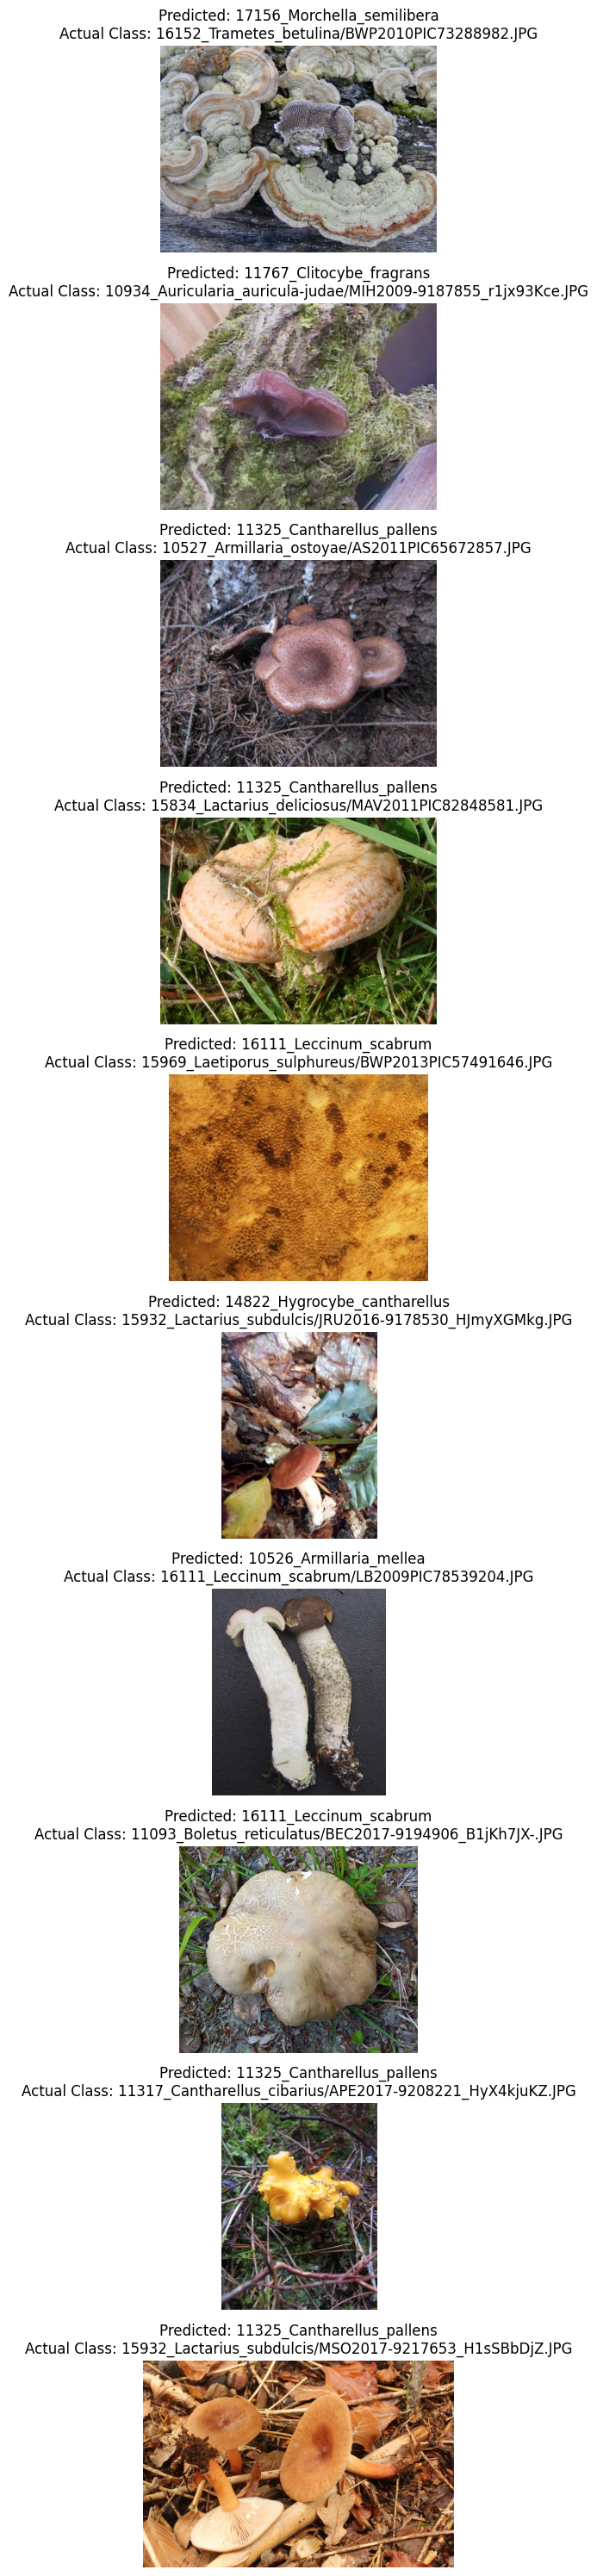

In [50]:
# Select random images from a directory
random_images = select_random_images('dataset/val', num_images=10)

# Perform inference and display the images with predictions and file names
display_predictions(random_images, model, transform)
